Feature Selction 기준
1. 종속 변수와의 상관관계 (영향력 훑기 및 다중공선성 예방 feature 제거를 위함)

2. XGB 변수중요도 (one-hot 인코딩 수행)

3. XGB RFECV (one-hot 인코딩 수행)

4. Lasso, Lidge (one-hot 인코딩 수행)

후에 Label 인코딩도 진행해 볼 예정

모델 평가 기준

1. train set 기준 8: 2 = train : test 로 나누어 실험 후 SMAPE 평가

2. test set 예측 및 제출

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('./data/pp_train_v02.csv', encoding='utf-8')
df

,building_number,temperature,windspeed,humidity,power_consumption,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,...,windspeed_3,humidity_1,humidity_2,humidity_3,discomfort_1,discomfort_2,discomfort_3,holiday,ma_dis_3,ma_dis_5
0,1,18.6,0.9,42.0,1085.28,Other Buildings,110634.00,39570.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,False,63.093880,63.093880
1,1,18.0,1.1,45.0,1047.36,Other Buildings,110634.00,39570.00,0.0,0.0,...,0.0,3.0,0.0,0.0,-0.62988,0.00000,0.00000,False,62.778940,62.778940
2,1,17.7,1.5,45.0,974.88,Other Buildings,110634.00,39570.00,0.0,0.0,...,0.0,0.0,3.0,0.0,-0.37665,-1.00653,0.00000,False,62.548410,62.548410
3,1,16.7,1.4,48.0,953.76,Other Buildings,110634.00,39570.00,0.0,0.0,...,0.5,3.0,3.0,6.0,-1.18851,-1.56516,-2.19504,False,61.816730,62.136018
4,1,18.4,2.8,43.0,986.40,Other Buildings,110634.00,39570.00,0.0,0.0,...,1.7,-5.0,-2.0,-2.0,1.98904,0.80053,0.42388,False,61.958023,62.286390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,0.9,86.0,881.04,Hotel and Resort,57497.84,40035.23,0.0,0.0,...,-0.5,12.0,16.0,14.0,-2.05692,-2.98766,-2.60734,False,74.061867,74.322108
203996,100,22.4,1.3,86.0,798.96,Hotel and Resort,57497.84,40035.23,0.0,0.0,...,-0.6,0.0,12.0,16.0,-1.16298,-3.21990,-4.15064,False,72.678320,73.678128
203997,100,21.3,1.0,92.0,825.12,Hotel and Resort,57497.84,40035.23,0.0,0.0,...,-0.3,6.0,6.0,18.0,-1.42032,-2.58330,-4.64022,False,71.131580,72.640000
203998,100,21.0,0.3,94.0,640.08,Hotel and Resort,57497.84,40035.23,0.0,0.0,...,-0.6,2.0,8.0,8.0,-0.38644,-1.80676,-2.96974,False,70.141667,71.448520


C:\Users\magne\AppData\Local\Temp/ipykernel_8416/4083026822.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix, dtype=np.bool)


Text(0.5, 1.0, 'Diagonal Correlation HeatMap')

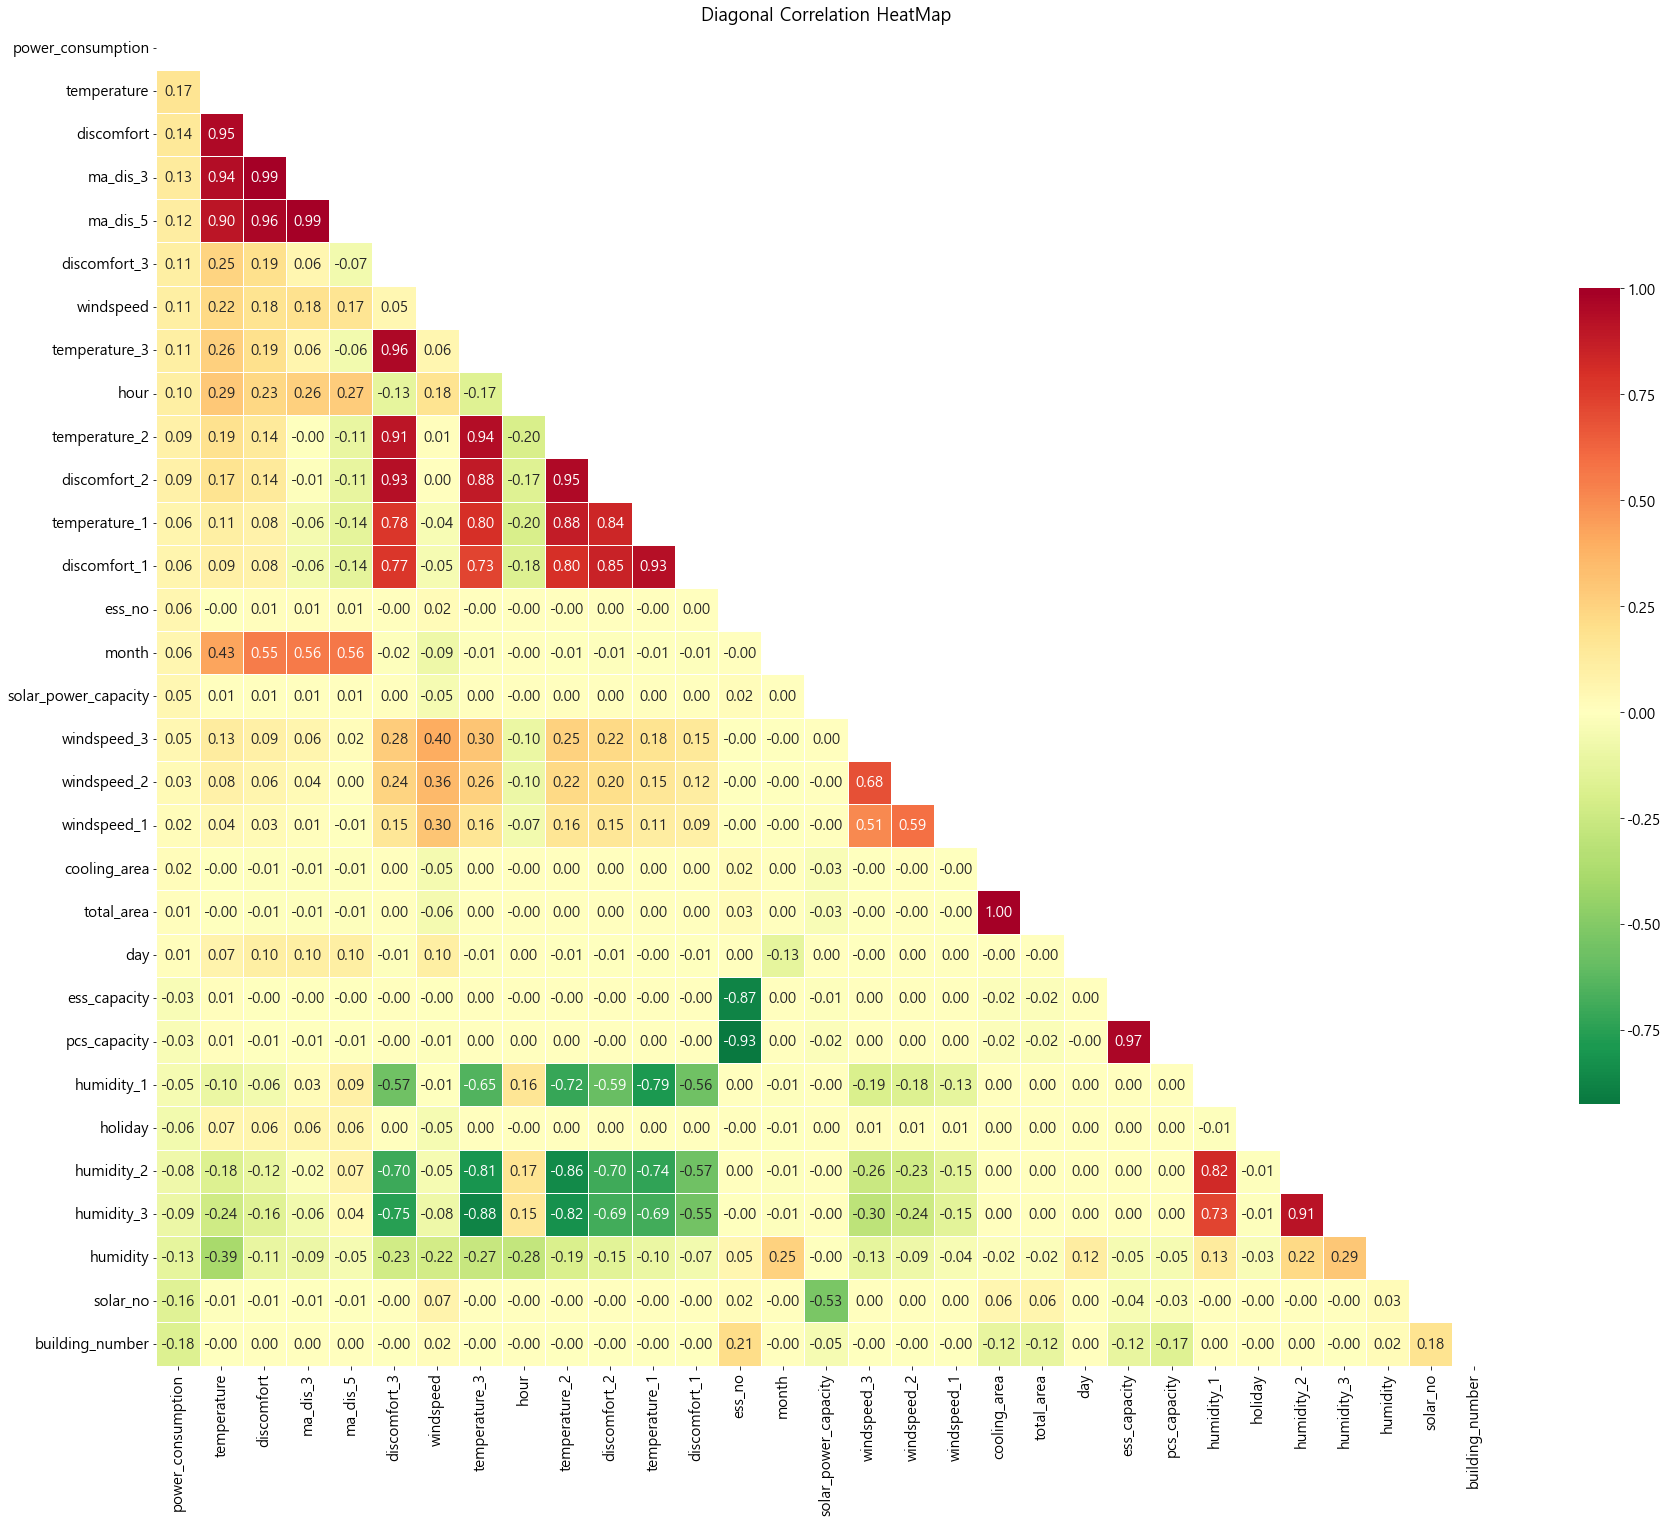

In [3]:
plt.rc('font', family='Malgun Gothic')
plt.rc('font', size=15)
plt.rc('axes', unicode_minus=False)


corr_matrix = df.corr()
corr_matrix = corr_matrix.sort_values(by = 'power_consumption', axis = 0, ascending=False)
corr_matrix = corr_matrix[corr_matrix.index]

# 상관관계의 시각적 표현
f, ax = plt.subplots(figsize=(30, 30))
corr = df.select_dtypes(exclude=["object","bool"]).corr()

# 대각 행렬을 기준으로 한 쪽만 나타나게 설정해줍니다.
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

g = sns.heatmap(corr_matrix, cmap='RdYlGn_r', vmax= 1, mask=mask, 
center=0, annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Diagonal Correlation HeatMap")

In [7]:
df.describe()

,building_number,temperature,windspeed,humidity,power_consumption,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,...,temperature_3,windspeed_1,windspeed_2,windspeed_3,humidity_1,humidity_2,humidity_3,discomfort_1,discomfort_2,discomfort_3
count,203981.000000,203981.000000,203981.000000,203981.000000,203981.000000,203981.000000,203981.000000,203981.000000,203981.000000,203981.000000,...,203981.000000,203981.000000,203981.000000,203981.000000,203981.000000,203981.000000,203981.000000,203981.000000,203981.000000,203981.000000
mean,50.498787,25.543328,2.134031,78.716354,2451.062288,11.497002,10.402204,1.458207,0.365204,0.317283,...,0.007700,-0.005816,-0.008345,-0.009757,0.015310,0.028341,-0.000901,0.003939,0.008481,0.013516
std,28.865541,3.779281,1.358109,15.080294,2440.727607,1.011556,2.459685,2.044230,1.596693,1.386109,...,2.009784,0.799640,0.948850,1.057540,4.172524,6.861438,9.182907,0.947297,1.614948,2.228128
min,1.000000,10.100000,0.000000,13.000000,0.000000,8.626657,0.000000,0.000000,0.000000,0.000000,...,-10.900000,-5.700000,-6.600000,-6.000000,-39.000000,-41.000000,-46.000000,-9.121670,-9.879240,-10.146810
25%,25.000000,23.400000,1.200000,69.000000,1085.760000,11.024766,9.923143,0.000000,0.000000,0.000000,...,-1.200000,-0.500000,-0.600000,-0.600000,-2.000000,-3.000000,-4.000000,-0.537030,-0.967580,-1.385520
50%,50.000000,25.700000,2.000000,81.000000,1766.340000,11.443725,10.934178,0.000000,0.000000,0.000000,...,-0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.087090,-0.179010,-0.290440
75%,75.000000,28.100000,2.800000,91.000000,2970.000000,12.142797,11.508956,3.555348,0.000000,0.000000,...,1.200000,0.500000,0.500000,0.600000,2.000000,4.000000,5.000000,0.481120,0.859120,1.260000
max,100.000000,37.100000,13.300000,100.000000,25488.400000,16.370633,16.208114,6.431331,8.039157,6.907755,...,9.800000,5.600000,7.000000,7.800000,41.000000,47.000000,54.000000,6.607970,10.676090,13.100210


ess_capacity, pcs_capacity 는 상관관계가 1.00 으로 다중공선성의 문제가 있음

따라서 pcs_capacity 제거

In [4]:
df.drop('pcs_capacity', axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   building_number       204000 non-null  int64  
 1   temperature           204000 non-null  float64
 2   windspeed             204000 non-null  float64
 3   humidity              204000 non-null  float64
 4   power_consumption     204000 non-null  float64
 5   building_type         204000 non-null  object 
 6   total_area            204000 non-null  float64
 7   cooling_area          204000 non-null  float64
 8   solar_power_capacity  204000 non-null  float64
 9   ess_capacity          204000 non-null  float64
 10  hour                  204000 non-null  int64  
 11  day                   204000 non-null  int64  
 12  month                 204000 non-null  int64  
 13  solar_no              204000 non-null  bool   
 14  ess_no                204000 non-null  bool   
 15  

In [6]:
df['building_type'] = df['building_type'].astype('category')

In [7]:
df_encoded = pd.get_dummies(df)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 42 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   building_number                            204000 non-null  int64  
 1   temperature                                204000 non-null  float64
 2   windspeed                                  204000 non-null  float64
 3   humidity                                   204000 non-null  float64
 4   power_consumption                          204000 non-null  float64
 5   total_area                                 204000 non-null  float64
 6   cooling_area                               204000 non-null  float64
 7   solar_power_capacity                       204000 non-null  float64
 8   ess_capacity                               204000 non-null  float64
 9   hour                                       204000 non-null  int64  
 10  day     

In [8]:
X = df_encoded.drop('power_consumption', axis=1)
y = df_encoded['power_consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y)

print(X_train.shape)

(153000, 41)


In [9]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [10]:
importance = xgbr.feature_importances_
feature = X.columns
importances = pd.DataFrame()
importances['feature'] = feature
importances['importances'] = importance
importances.sort_values('importances', ascending=False, inplace=True)
importances.reset_index(drop=True, inplace=True)
importances

,feature,importances
0,building_type_Data Center,0.637591
1,total_area,0.092155
2,building_type_Research Institute,0.049346
3,building_type_University,0.044925
4,building_type_Hospital,0.038988
5,building_type_Apartment,0.032663
6,building_number,0.029150
7,building_type_Department Store and Outlet,0.014677
8,cooling_area,0.009385
9,hour,0.008649


In [78]:
from sklearn.feature_selection import RFECV

estimator = XGBRegressor()

selector = RFECV(estimator, step=1, min_features_to_select=10, cv=10, scoring='neg_mean_absolute_error')

#fit the model, get a rank of the variables, and a matrix of the selected X variables
selector = selector.fit(X_train, y_train)

a = selector.support_.reshape(1,-1)
df_a = pd.DataFrame(columns=X_train.columns, data=a)
true_columns = df_a.columns[df_a.iloc[0]].tolist()

print(true_columns)

KeyboardInterrupt: 

작업시간이 너무 길어져 슈퍼컴 사용

In [83]:
from sklearn.linear_model import Ridge, Lasso


ridge_alpha = 0.01
lasso_alpha = 0.001

rid = Ridge(alpha = ridge_alpha)
las = Lasso(alpha = lasso_alpha)

X_train= np.array(X_train)
y_train= np.array(y_train).reshape(-1,1)

rid.fit(X_train,y_train)
las.fit(X_train,y_train)

rid.coef_, las.coef_

C:\Users\magne\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283700295530.65436, tolerance: 91263758.86762667
  model = cd_fast.enet_coordinate_descent(


(array([[-1.03737223e+02,  2.03090187e+02,  2.05820378e+02,
          8.70744071e+00,  5.92569217e+02,  1.12164449e+01,
         -9.17725448e+01, -2.65722633e+02,  2.24379119e+01,
         -5.83101662e-01,  1.40661548e+02, -5.69424529e+02,
         -1.58989821e+03, -1.02052487e+02, -7.16399920e+01,
          2.26287579e+00, -2.21329164e+00, -5.26939970e+01,
         -4.88521621e+01, -2.82896542e+01, -7.68873606e+00,
          5.58750761e+00, -5.53641977e+00,  4.21587644e+01,
         -1.15508330e+01,  1.16603865e+02, -3.40765352e+02,
         -5.33308854e+02,  2.05297254e+02,  1.93263572e+03,
         -1.56122251e+03,  2.74624677e+03, -2.69532085e+02,
          3.62480704e+03,  1.93111920e+03, -5.14529217e+03,
         -4.51653384e+03,  2.23694168e+03, -6.51158177e+02]]),
 array([-1.03659123e+02,  2.02678737e+02,  2.05783454e+02,  8.68000919e+00,
         5.92594216e+02,  1.12238140e+01, -9.18123428e+01, -2.63034358e+02,
         2.24403461e+01, -5.82147129e-01,  1.40602100e+02, -5.696

In [84]:
a = rid.coef_.reshape(1,-1)
df_a = pd.DataFrame(columns=X.columns, data=a)
df_a

,building_number,temperature,windspeed,humidity,total_area,cooling_area,solar_power_capacity,ess_capacity,hour,day,...,building_type_Data Center,building_type_Department Store and Outlet,building_type_Discount Mart,building_type_Hospital,building_type_Hotel and Resort,building_type_Knowledge Industry Center,building_type_Other Buildings,building_type_Public,building_type_Research Institute,building_type_University
0,-103.737223,203.090187,205.820378,8.707441,592.569217,11.216445,-91.772545,-265.722633,22.437912,-0.583102,...,1932.635721,-1561.222513,2746.246767,-269.532085,3624.807041,1931.119203,-5145.292167,-4516.533838,2236.941679,-651.158177


In [85]:
aaa = df_a.columns.tolist()

fli=[]
coli=[]
for i, col in enumerate(aaa) :
    fli.append(col)
    coli.append(df_a.iloc[0,i])
    
dd = pd.DataFrame({'feature':fli, 'coef':coli})

dd.sort_values('coef', ascending=False, inplace=True)
dd.reset_index(drop=True, inplace=True)
dd

,feature,coef
0,building_type_Hotel and Resort,3624.807041
1,building_type_Discount Mart,2746.246767
2,building_type_Research Institute,2236.941679
3,building_type_Data Center,1932.635721
4,building_type_Knowledge Industry Center,1931.119203
5,total_area,592.569217
6,windspeed,205.820378
7,building_type_Commercial,205.297254
8,temperature,203.090187
9,month,140.661548


In [86]:
b = las.coef_.reshape(1,-1)
df_b = pd.DataFrame(columns=X.columns, data=b)
# df_b
true_columns = df_b.columns[df_b.iloc[0] != 0].tolist()
print(true_columns)

['building_number', 'temperature', 'windspeed', 'humidity', 'total_area', 'cooling_area', 'solar_power_capacity', 'ess_capacity', 'hour', 'day', 'month', 'solar_no', 'ess_no', 'discomfort', 'temperature_1', 'temperature_2', 'temperature_3', 'windspeed_1', 'windspeed_2', 'windspeed_3', 'humidity_1', 'humidity_2', 'humidity_3', 'discomfort_1', 'discomfort_2', 'discomfort_3', 'holiday', 'building_type_Apartment', 'building_type_Commercial', 'building_type_Data Center', 'building_type_Department Store and Outlet', 'building_type_Discount Mart', 'building_type_Hospital', 'building_type_Hotel and Resort', 'building_type_Knowledge Industry Center', 'building_type_Other Buildings', 'building_type_Public', 'building_type_Research Institute', 'building_type_University']
